* img_show - показать базу

## Libraries

In [ ]:
from tensorflow.keras.datasets import mnist, cifar10 #Загружаем базу mnist
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential, Model, load_model #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,\
         Dropout, BatchNormalization, Input, concatenate, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop # оптимизаторы
from tensorflow.keras.utils import to_categorical, plot_model as pm #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
import cv2
from tqdm.notebook import tqdm as tq

# Вариант 1

## Function

In [ ]:
def create_xtrain(path, h, w, augm=True, proc=10, h2=96, w2=160):
  classes = []
  list_path = []
  folder_len = []
  Xtrain = []
  Ytrain = []
  temporary_x = []
  temporary_y = []

  for adress, dir, files in os.walk(path):
    if len(files) != 0:
      a = adress.split('/')
      classes.append(a[-1])
      folder_len.append(len(files))
      list_path.append(adress)

  for i in tq(range(len(classes)), desc='Количество классов'):
    for s in tq(range(folder_len[i]), desc='Длина {} класса для x_train'.format(i+1)):
      temporary_x.append(image.img_to_array(image.load_img(os.path.join(list_path[i], os.listdir(list_path[i])[s]), target_size=(h,w))))
  Xtrain = np.array(temporary_x)
  print('X_train:', Xtrain.shape)
  print('='*85)  

  for i in tq(range(len(folder_len)), desc='Количество классов'):
    for n in tq(range(folder_len[i]), desc='Длина {} класса для y_train'.format(i+1)):
      temporary_y.append(i)
  Ytrain = np.array(temporary_y)
  Xtrain = Xtrain / 255

  print('Y_train:', Ytrain.shape)
  print('='*85)
  print('Classes:', classes)

  x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size=0.2, shuffle=True)

  if augm == True:
    print()
    print('Аугментируем...')
    proc = proc / 100
    x_train_bias = [] # смещаем одну картинку 4 раза
    y_train_bias = []
    n = int(proc * x_train[0].shape[0])
    for t in range(4):    
      if t == 0:
        for i in tq(range(x_train.shape[0]), desc='1'):
          x_train_bias.append(x_train[i][n:,n:])
          y_train_bias.append(y_train[i])
      if t == 1:
        for i in tq(range(x_train.shape[0]), desc='2'):
          x_train_bias.append(x_train[i][:-n,:-n])
          y_train_bias.append(y_train[i])
      if t == 2:
        for i in tq(range(x_train.shape[0]), desc='3'):
          x_train_bias.append(x_train[i][n:,:-n])
          y_train_bias.append(y_train[i])
      if t == 3:
        for i in tq(range(x_train.shape[0]), desc='4'):
          x_train_bias.append(x_train[i][:-n, n:])
          y_train_bias.append(y_train[i])

    x_train_bias = np.array(x_train_bias)
    y_train_bias = np.array(y_train_bias)

    xtrain = [resize(x_train[i], (x_train_bias.shape[1], x_train_bias.shape[2])) for i in tq(range(x_train.shape[0]), desc='resize x_train')]
    x_train = np.array(xtrain)


    x_train_bias = np.array(x_train_bias)
    y_train_bias = np.array(y_train_bias)
    x_train = np.concatenate((x_train, x_train_bias))
    y_train = np.concatenate((y_train, y_train_bias))

    x_train2 = [x_train[i][::, ::-1] for i in tq(range(x_train.shape[0]), desc='Зеркалим')]
    print('Соединяем xtrain + xtrain_mirror...')
    x_train = np.array(np.concatenate((x_train, x_train2)))
    print('Соединяем ytrain + ytrain_mirror...')
    y_train = np.array(np.concatenate((y_train, y_train)))



  xtrain = [resize(x_train[i], (h2, w2)) for i in tq(range(x_train.shape[0]), desc='resize x_train')]
  x_train = np.array(xtrain)
  xtest = [resize(x_test[i], (h2, w2)) for i in tq(range(x_test.shape[0]), desc='resize x_test')]
  x_test = np.array(xtest) 

 

  print('x_train:', x_train.shape)
  print('y_train:', y_train.shape)
  print('x_test:', x_test.shape)
  print('y_test:', y_test.shape)

  return (x_train, x_test, y_train, y_test, classes)

# ====================================================== Просмотр изображений =========================================================================

def img_show(x, y):
  plt.figure(figsize=(25, 5))
  for i in range(6):
    n = np.random.randint(0, x.shape[0])
    pr = classes[y[n]]
    ax = plt.subplot(2, 6, i+1)
    plt.imshow(x[n])
    plt.title(pr)
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)

    n = np.random.randint(0, x.shape[0])
    pr = classes[y[n]]
    ax = plt.subplot(2, 6, i+1+6)
    plt.imshow(x[n])
    plt.title(pr)
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
  plt.show()



from tensorflow.keras.models import load_model
import seaborn as sns
sns.set_style('darkgrid')

class CallBacK():
  
  def on_train_begin(self, logs):

    print('\u001b[36m','========= Education =========',  '\u001b[0m')
    print('------------------------------')
    self.curr = {}
    self.best_val = 0
    self.path = '/content/best_model_2.h5'

    self.hs = {}
    self.hs['loss'] = []
    self.hs['val_loss'] = []
    self.hs['accuracy'] = []
    self.hs['val_accuracy'] = []


  def on_epoch_end(self, epoch, logs):

    self.hs['loss'].append(logs['loss'])
    self.hs['val_loss'].append(logs['val_loss'])
    self.hs['accuracy'].append(logs['accuracy'])
    self.hs['val_accuracy'].append(logs['val_accuracy'])
    self.curr_val = round(logs['val_accuracy'], 4)
    self.curr[epoch] = self.curr_val

    if self.best_val < self.curr_val:
      self.best_val = self.curr_val
      model.save(self.path)
    # print('Epoch: {} ===> val_acc: {}'.format(epoch+1, self.curr_val))
    print('Best:', self.best_val)

  def on_train_end(self, logs):
    global model
    model = load_model(self.path)

    for key, val in self.curr.items():
      if val == max(self.curr.values()):
        print('\u001b[44m', '\u001b[37;1m', 'epoch: {} val_acc: {}'.format(key+1,val), '\u001b[0m')
      else:
        print('epoch: {} val_accuracy: {} '.format(key+1,val))
    print('-------------------------------')
    print('\u001b[36m', '====== Training completed ====', '\u001b[0m')
    print('===============================')

    plt.figure(2, figsize=(16,5))

    plt.subplot(121) # 1 строка 2 столбца 1 график
    plt.title('Accuracy', fontsize=18, color='grey')
    plt.plot(self.hs['accuracy'], label='accuracy', c='blue')
    plt.plot(self.hs['val_accuracy'], label='val_accuracy', c='red')
    plt.ylabel('% accuracy', fontsize = 13, color = 'grey')
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
    plt.legend()

    plt.subplot(122) # 1 строка 2 столбца 2 график
    plt.title('Loss', fontsize=18, color='grey')
    plt.plot(self.hs['loss'], label='loss', c='blue')
    plt.plot(self.hs['val_loss'], label='val_loss', c='red')
    plt.ylabel('error', fontsize = 13, color = 'grey')
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
    plt.legend()
    plt.show()


CaLL = CallBacK()

lamCB = LambdaCallback(on_train_begin = CaLL.on_train_begin,
                       on_epoch_end = CaLL.on_epoch_end,
                       on_train_end = CaLL.on_train_end)



## Preparation

### Формируем x_train and y_train

---



In [ ]:
# !unzip -q "/content/drive/MyDrive/cars3.zip" -d /content/cars

In [ ]:
path = '/content/cars'
h2 = 96
w2 = 160
h = 108
w = 192

# (path, h, w, augm=True, proc=10, h2=96, w2=160)

x_train, x_test, y_train, y_test, classes = create_xtrain(path, h, w, True, 10, h2, w2) 

Количество классов:   0%|          | 0/3 [00:00<?, ?it/s]

Длина 1 класса для x_train:   0%|          | 0/1180 [00:00<?, ?it/s]

Длина 2 класса для x_train:   0%|          | 0/1180 [00:00<?, ?it/s]

Длина 3 класса для x_train:   0%|          | 0/1180 [00:00<?, ?it/s]

X_train: (3540, 108, 192, 3)


Количество классов:   0%|          | 0/3 [00:00<?, ?it/s]

Длина 1 класса для y_train:   0%|          | 0/1180 [00:00<?, ?it/s]

Длина 2 класса для y_train:   0%|          | 0/1180 [00:00<?, ?it/s]

Длина 3 класса для y_train:   0%|          | 0/1180 [00:00<?, ?it/s]

Y_train: (3540,)
Classes: ['Mercedes', 'Renault', 'Ferrari']

Аугментируем...


1:   0%|          | 0/2832 [00:00<?, ?it/s]

2:   0%|          | 0/2832 [00:00<?, ?it/s]

3:   0%|          | 0/2832 [00:00<?, ?it/s]

4:   0%|          | 0/2832 [00:00<?, ?it/s]

resize x_train:   0%|          | 0/2832 [00:00<?, ?it/s]

Зеркалим:   0%|          | 0/14160 [00:00<?, ?it/s]

Соединяем xtrain + xtrain_mirror...
Соединяем ytrain + ytrain_mirror...


resize x_train:   0%|          | 0/28320 [00:00<?, ?it/s]

resize x_test:   0%|          | 0/708 [00:00<?, ?it/s]

x_train: (28320, 96, 160, 3)
y_train: (28320,)
x_test: (708, 96, 160, 3)
y_test: (708,)


In [ ]:
!uptime -p

up 10 hours, 48 minutes


### Посмотрим на базу

In [ ]:
img_show(x_train, y_train)

## Education

In [ ]:
Y_train = to_categorical(y_train, 3)
Y_test = to_categorical(y_test, 3)
print(Y_train.shape)
print(Y_test.shape)

(28320, 3)
(708, 3)


In [ ]:
n0 = 64
n1 = 128
n2 = 256
n3 = 512
dr = 0.4


def conv(n):
  return Conv2D(n, (3, 3), padding='same', activation='relu')

def MaxDr(dr):
  return Dropout(dr)(MaxPooling2D()(x))


inp = Input(shape=(x_train.shape[1:]))
x = conv(n2)(inp)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n1)(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
out = Dense(3, activation='softmax')(x)

model = Model(inp, out)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 160, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 160, 256)      7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 160, 512)      1180160   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 80, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 80, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 80, 512)       2359808   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 80, 512)       235980

In [ ]:
pm(model, show_shapes=True)

In [ ]:
x_train.shape[1:]

(40, 60, 3)

In [ ]:
model.compile(optimizer= Adam(0.000001), loss='categorical_crossentropy', metrics='accuracy')
model.fit(x_train, Y_train,
          batch_size=8, epochs=2,
          validation_data=(x_test, Y_test),
          verbose=1, callbacks=lamCB)

 ========= Education ========= 
------------------------------
Epoch 1/2
3540/3540 [==============================] - 487s 136ms/step - loss: 0.0631 - accuracy: 0.9862 - val_loss: 0.0689 - val_accuracy: 0.9831
Best: 0.9831
Epoch 2/2
3540/3540 [==============================] - 483s 137ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 0.0873 - val_accuracy: 0.9873
Best: 0.9873
epoch: 1 val_accuracy: 0.9831 
  epoch: 2 val_acc: 0.9873 
-------------------------------
 ====== Training completed ==== 


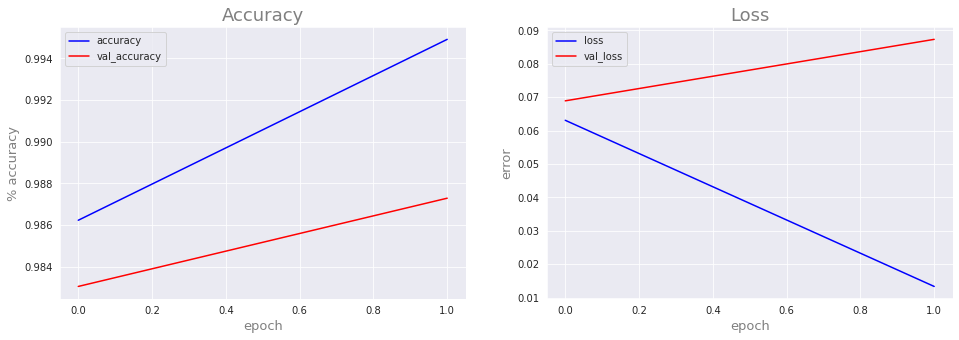

In [ ]:
model.compile(optimizer= Adam(0.00001), loss='categorical_crossentropy', metrics='accuracy')
model.fit(x_train, Y_train,
          batch_size=8, epochs=2,
          validation_data=(x_test, Y_test),
          verbose=1, callbacks=lamCB)

In [ ]:
model.save('/content/drive/MyDrive/Базы/new_fmr_9124.h5')

## Examination

In [ ]:
! unzip -q '/content/drive/MyDrive/Colab Notebooks/Project/Xtest.zip' -d /content/

In [ ]:
model = load_model('/content/drive/MyDrive/Базы/new_fmr_9124.h5')

In [ ]:
model.summary()

In [ ]:
model.evaluate(x_test, Y_test)

In [ ]:
path = '/content/Xtest/Xtest'
folder = os.listdir(path)
y_val = folder

h = 96
w = 160
x_val = []

for i in range(len(folder)):
  x_val.append(image.img_to_array(image.load_img(os.path.join(path, folder[i]), target_size=(h,w))))

x_val = np.array(x_val)
x_val/=255
Yval = []
for i in y_val:
  if 'mercedes' in i: 
    Yval.append(0)
  elif 'ferrari' in i:
    Yval.append(2)
  else:
    Yval.append(1)
Yval = np.array(Yval)

In [ ]:
y_val = to_categorical(Yval, 3)

In [ ]:
print(x_val.shape)
print(y_val.shape)

(32, 96, 160, 3)
(32, 3)


In [ ]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 346ms/step - loss: 3.5526 - accuracy: 0.7812


[3.5526013374328613, 0.78125]

In [ ]:
model.summary()

In [ ]:
classes

['Mercedes', 'Renault', 'Ferrari']

In [ ]:
Yval

array([0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2,
       0, 0, 1, 1, 1, 2, 1, 2, 1, 1])

In [ ]:
print(Yval[:5])
print(y_val[:5])

[0 2 2 0 0]
['mercedes_9.jpg' 'ferrari_8.jpg' 'ferrari_9.jpg' 'mercedes_4.jpg'
 'mercedes_8.jpg']


In [ ]:
pred = model.predict(x_val)

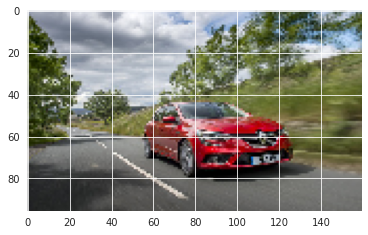

Распознанный браз на картинке:  Mercedes
Правильный ответ:  Renault


In [ ]:
n = np.random.randint(0,x_val.shape[0])
pred = model.predict(x_val)

plt.imshow(x_val[n])
plt.show()
print("Распознанный браз на картинке: ", classes[np.argmax(pred[n])])
print("Правильный ответ: ", classes[Yval[n]])

In [ ]:
32/8

4.0

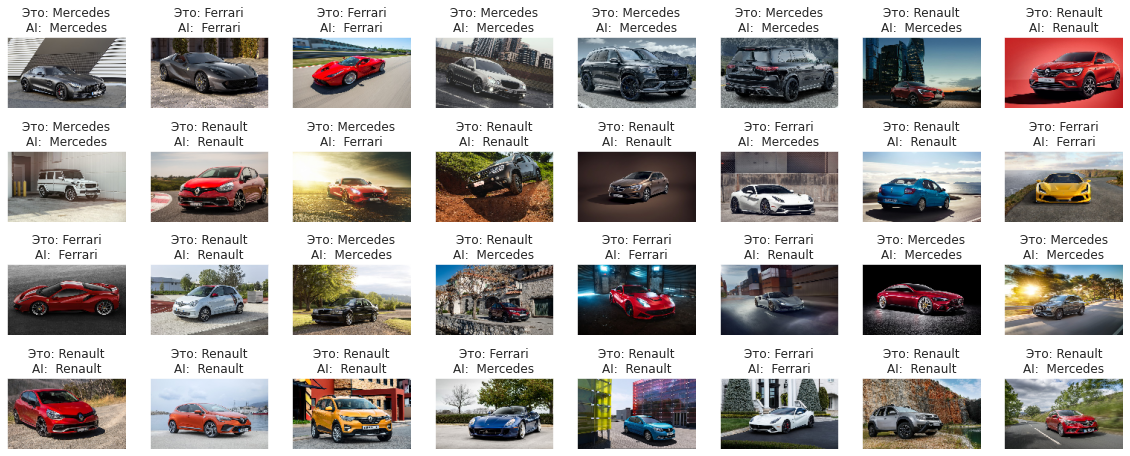

In [ ]:
plt.figure(figsize=(20,8))
for i in range(32):
  plt.subplot(4,8, i+1)
  plt.title(str('Это: ' + classes[Yval[i]]) + '\n' + 'AI:  ' + str(classes[np.argmax(pred[i])]))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_val[i])

In [ ]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 138ms/step - loss: 3.5526 - accuracy: 0.7812


[3.5526013374328613, 0.78125]

# Вариант 2

In [ ]:
# !unzip -q "/content/drive/MyDrive/cars3.zip" 

train_path = '/content/cars/cars3' # Папка с папками картинок, рассортированных по категориям
batch_size = 32 # Размер выборки
h = 96 # Ширина изображения (192)
w = 160 # Высота изображения (128)

In [ ]:
#@title ImageDatagenerator { display-mode: "form" }
# Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, # Значения цвета меняем на дробные показания
    rotation_range=10, # Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.2, # Зумируем изображения при генерации выборки
    horizontal_flip=True, # Отзеркаливание изображений
    fill_mode='nearest', # Заполнение пикселей вне границ ввода
    validation_split=0.2) # Указываем разделение изображений на обучающую и тестовую выборку

In [ ]:
# Обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='training') # Устанавливаем как набор для обучения

# Проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size, # Размер batch_size
    class_mode='categorical', # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, # Перемешивание выборки
    subset='validation') # Устанавливаем как валидационный набор


Found 2832 images belonging to 3 classes.
Found 708 images belonging to 3 classes.


In [ ]:
#@title Посмортерть изображения
plt.figure(figsize=(20,8))
for i in range(32):
  plt.subplot(4,8, i+1)
  # plt.title(str(classes[Yval[i]]) + '\n' + str(classes[np.argmax(pred[i])]))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_generator[i])

In [ ]:
#@title Model
n0 = 64
n1 = 128
n2 = 256
n3 = 512
dr = 0.4


def conv(n):
  return Conv2D(n, (3, 3), padding='same', activation='relu')

def MaxDr(dr):
  return Dropout(dr)(MaxPooling2D()(x))


inp = Input(shape=(w, h, 3))
x = conv(n2)(inp)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n3)(x)
x = conv(n3)(x)
x = MaxDr(dr)

x = conv(n1)(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2048, activation='relu')(x)
out = Dense(3, activation='softmax')(x)

model = Model(inp, out)

In [ ]:
model.compile(optimizer= Adam(0.000001), loss='categorical_crossentropy', metrics='accuracy')

 ========= Education ========= 
------------------------------
Epoch 1/20
88/88 [==============================] - 36s 399ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.7019 - val_accuracy: 0.8778
Best: 0.8778
Epoch 2/20
88/88 [==============================] - 35s 395ms/step - loss: 0.0061 - accuracy: 0.9975 - val_loss: 0.6507 - val_accuracy: 0.8949
Best: 0.8949
Epoch 3/20
88/88 [==============================] - 35s 397ms/step - loss: 0.0092 - accuracy: 0.9979 - val_loss: 0.7164 - val_accuracy: 0.8750
Best: 0.8949
Epoch 4/20
88/88 [==============================] - 35s 395ms/step - loss: 0.0077 - accuracy: 0.9964 - val_loss: 0.7763 - val_accuracy: 0.8821
Best: 0.8949
Epoch 5/20
88/88 [==============================] - 35s 397ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.7253 - val_accuracy: 0.8793
Best: 0.8949
Epoch 6/20
88/88 [==============================] - 35s 395ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.7204 - val_accuracy: 0.8835
Best: 0.8949
E

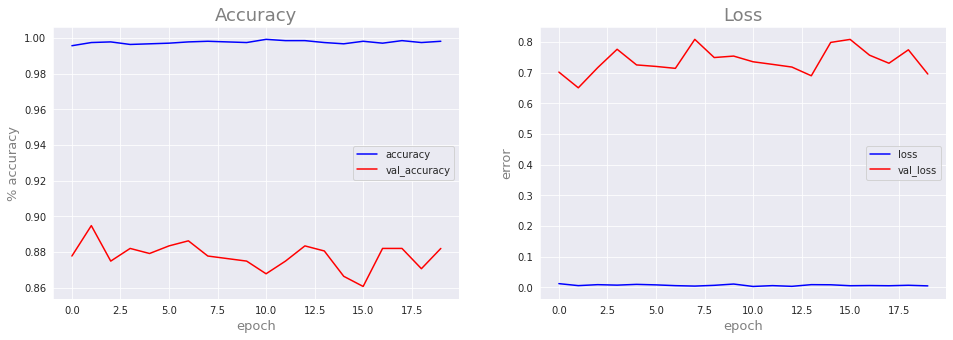

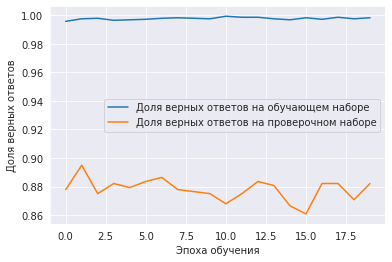

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=20,
    verbose=1, callbacks=lamCB)